In [180]:
import pandas as pd
import numpy as np
mturk_race = pd.read_csv("../allData/MTURK_RACE.csv", header = 1)
#print(mturk_race)
#mturk_race.set_index('id')
guess = mturk_race.set_index('id').sum(axis=1).rename("guess")
#print(guess)
raw_data = pd.read_csv("../allData/BROWARD_CLEAN_SUBSET.csv", index_col = 1)
#print(raw_data)

#guess[0]
raw_data = raw_data.join(guess)
raw_data['pred'] = np.where((raw_data['guess'] > 5), raw_data['two_year_recid'], None)
raw_data['pred'] = np.where((raw_data['guess'] < -5), raw_data['two_year_recid']+1, raw_data['pred'])
raw_data.loc[raw_data['pred'] == 2, 'pred'] = 0

labels = ["<25", "25-45", ">45"]
raw_data['age_cat'] = pd.cut(raw_data.age, [0, 25, 46, 200], right=False, labels=labels)
raw_data.loc[raw_data['sex'] == 1, 'sex'] = 'Female'
raw_data.loc[raw_data['sex'] == 0, 'sex'] = 'Male'
raw_data.loc[raw_data['race'] == 1, 'race'] = 'Caucasian'
raw_data.loc[raw_data['race'] == 2, 'race'] = 'African American'
raw_data.loc[raw_data['race'] == 3, 'race'] = 'Hispanic'
raw_data.loc[raw_data['race'] == 4, 'race'] = 'Asian'
raw_data.loc[raw_data['race'] == 5, 'race'] = 'Native American'
raw_data.loc[raw_data['race'] == 6, 'race'] = 'Other'
#1: White (Caucasian); 2: Black (African American); 3: Hispanic; 4: Asian; 5: Native American; 6: Other
#raw_data


In [181]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness

Text(0.5,1,'two_year_recid')

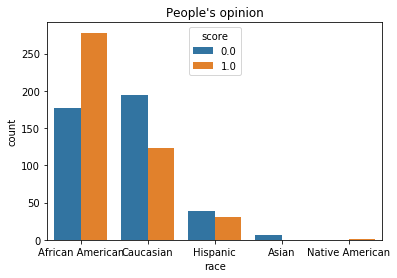

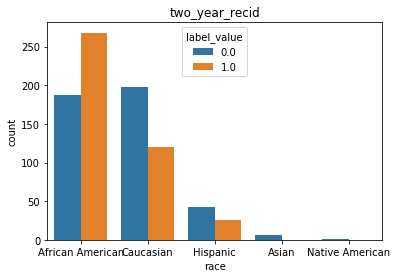

In [182]:
raw_data.loc[raw_data['pred'] == 0, 'score'] = 0
raw_data.loc[raw_data['pred'] == 1, 'score'] = 1

#actual rate
raw_data.loc[raw_data['two_year_recid'] == 0, 'label_value'] = 0
raw_data.loc[raw_data['two_year_recid'] == 1, 'label_value'] = 1
raw_data = raw_data.dropna()

plt.figure()
#g = sns.countplot(x="race", hue="score", data=raw_data[raw_data.race.isin(['African-American', 'Caucasian', 'Hispanic'])])
g = sns.countplot(x="race", hue="score", data=raw_data)
plt.title('People\'s opinion')

plt.figure()
#g = sns.countplot(x="race", hue="label_value", data=raw_data[raw_data.race.isin(['African-American', 'Caucasian', 'Hispanic'])])
g = sns.countplot(x="race", hue="label_value", data=raw_data)
plt.title('two_year_recid')


In [183]:
import numpy as np
#raw_data['days_b_screening_arrest']
#raw_data['days_b_screening_arrest'].fillna(-1, inplace=True)
#raw_data.fillna(-1, inplace=True) # TODO properly
#raw_data.replace(np.nan, 'aaaa', inplace = True)['days_b_screening_arrest']
#raw_data['days_b_screening_arrest']
raw_data = raw_data[['race', 'sex','age_cat', 'score', 'label_value']].dropna()
raw_data['age_cat'] = raw_data['age_cat'].astype(str)
print(raw_data['age_cat'])
list(raw_data)

id
8267       >45
5593     25-45
61         >45
5438       <25
5557       >45
9924     25-45
4767     25-45
1733       >45
4766     25-45
5647     25-45
8827     25-45
1443     25-45
7652     25-45
3732     25-45
1024     25-45
10307    25-45
6064     25-45
10452    25-45
8141       <25
3398       <25
8104     25-45
9644       <25
4105     25-45
8517       <25
4841       >45
1441     25-45
9435       <25
1741       <25
7324     25-45
2910     25-45
         ...  
10377    25-45
9875     25-45
1331       <25
6315     25-45
5103     25-45
10289    25-45
1215       >45
3285       >45
3869     25-45
203        <25
9337     25-45
173      25-45
5877     25-45
3236     25-45
9165     25-45
6788       >45
10068      <25
8876     25-45
2507     25-45
9473     25-45
2934     25-45
1670       <25
5297     25-45
10394    25-45
5001       <25
7722       <25
7153       <25
7975       <25
7945     25-45
4536     25-45
Name: age_cat, Length: 848, dtype: object


['race', 'sex', 'age_cat', 'score', 'label_value']

In [188]:
raw_data, attr_cols_input = preprocess_input_df(raw_data, required_cols=['score', 'label_value'])
#df.replace(np.nan, None)
g = Group()
xtab, _ = g.get_crosstabs(raw_data, attr_cols = ['race', 'sex', 'age_cat'])
xtab[['attribute_name', 'attribute_value', 'fpr', 'fnr', 'tpr', 'tnr', 'for', 'fdr', 'group_size']].round(2)
#FOR = FN/(FN + TN)
#FDR false discovery rate

b = Bias()
bdf = b.get_disparity_predefined_groups(xtab, {'race':'Caucasian', 'sex':'Male', 'age_cat':'25-45'})

#bdf.columns
bdf[['attribute_name', 'attribute_value', 'ppr_disparity', 'pprev_disparity', 'fdr_disparity', 'for_disparity', 'fpr_disparity', 'fnr_disparity']]

f = Fairness(tau=0.3)
fdf = f.get_group_value_fairness(bdf)
gaf = f.get_group_attribute_fairness(fdf)
gaf

fdf[['attribute_name', 'attribute_value','Statistical Parity',
       'Impact Parity', 'FDR Parity', 'FPR Parity', 'FOR Parity', 'FNR Parity',
       'TypeI Parity', 'TypeII Parity', 'Unsupervised Fairness',
       'Supervised Fairness']]

model_id, score_thresholds 1 {'rank_abs': [432]}
COUNTS::: race
African American    455
Asian                 6
Caucasian           318
Hispanic             68
Native American       1
dtype: int64
COUNTS::: sex
Female    170
Male      678
dtype: int64
COUNTS::: age_cat
25-45    511
<25      170
>45      167
dtype: int64
get_disparity_predefined_group()


,attribute_name,attribute_value,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TypeI Parity,TypeII Parity,Unsupervised Fairness,Supervised Fairness
0,race,African American,True,True,True,True,True,True,True,True,True,True
1,race,Asian,False,False,NaN,False,False,NaN,False,False,False,False
2,race,Caucasian,True,True,True,True,True,True,True,True,True,True
3,race,Hispanic,False,True,True,True,True,True,True,True,False,True
4,race,Native American,False,True,True,False,NaN,NaN,False,NaN,False,False
5,sex,Female,False,True,True,True,True,True,True,True,False,True
6,sex,Male,True,True,True,True,True,True,True,True,True,True
7,age_cat,25-45,True,True,True,True,True,True,True,True,True,True
8,age_cat,<25,False,True,True,True,True,True,True,True,False,True
9,age_cat,>45,False,True,True,True,True,True,True,True,False,True
